In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os
%matplotlib inline
sys.path.insert(0, os.path.abspath('../src'))
import functions as fn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, f1_score, cohen_kappa_score
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
import pickle

In [2]:
bank_f = pd.read_csv('../Data/raw/bank-full.csv', sep = ';')

In [3]:
numerical_df, categorical_df = fn.num_cat_splitter(bank_f)

In [4]:
numerical_0out = fn.outlier_remover(numerical_df)

In [5]:
bank_0out = pd.concat([categorical_df, numerical_0out], axis=1)
bank_0out = bank_0out.dropna().reset_index(drop=True)

In [6]:
y = bank_0out['y']
X = bank_0out.drop('y', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

In [7]:
X_train_num, X_train_cat = fn.num_cat_splitter(X_train)
X_test_num, X_test_cat = fn.num_cat_splitter(X_test)

In [8]:
transformer = PowerTransformer().fit(X_train_num)

X_train_num_trans = transformer.transform(X_train_num)
X_test_num_trans = transformer.transform(X_test_num)

In [9]:
scaler = MinMaxScaler().fit(X_train_num_trans)

X_train_num_scal = transformer.transform(X_train_num_trans)
X_test_num_scal = transformer.transform(X_test_num_trans)

X_train_scaled = pd.DataFrame(X_train_num_scal, columns=X_train_num.columns)
X_test_scaled = pd.DataFrame(X_test_num_scal, columns=X_test_num.columns)

C:\Users\Pablo\Ironhack\Week_5\Mid_bootcamp_project\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
C:\Users\Pablo\Ironhack\Week_5\Mid_bootcamp_project\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


In [10]:
encoder = OneHotEncoder(drop='first').fit(X_train_cat)

X_train_cat_np = encoder.transform(X_train_cat).toarray()
X_test_cat_np = encoder.transform(X_test_cat).toarray()

X_train_cat_encoded = pd.DataFrame(X_train_cat_np, columns=encoder.get_feature_names_out())
X_test_cat_encoded = pd.DataFrame(X_test_cat_np, columns=encoder.get_feature_names_out())

In [11]:
X_train_transformed = pd.concat([X_train_scaled, X_train_cat_encoded], axis=1)
X_test_transformed = pd.concat([X_test_scaled, X_test_cat_encoded], axis=1)

# Model 1: Oversampled and KNN 5

In [12]:
ros = RandomOverSampler(random_state=23)
X_train_over, y_train_over = ros.fit_resample(X_train_transformed, y_train)
print(y_train_over.value_counts())

yes    29811
no     29811
Name: y, dtype: int64


In [14]:
top_model_knn5_over = KNeighborsClassifier(n_neighbors=5, weights = "uniform", p=3).fit(X_train_over, y_train_over)
topscore5_over = top_model_knn5_over.score(X_test_transformed, y_test)

print("The score for the K-NN model with 5 neighbours, weighted by uniform is {:.3f}".format(topscore5_over))

The score for the K-NN model with 5 neighbours, weighted by uniform is 0.775


In [15]:
y_train_pred_knn5_over = top_model_knn5_over.predict(X_train_over)
y_test_pred_knn5_over  = top_model_knn5_over.predict(X_test_transformed)

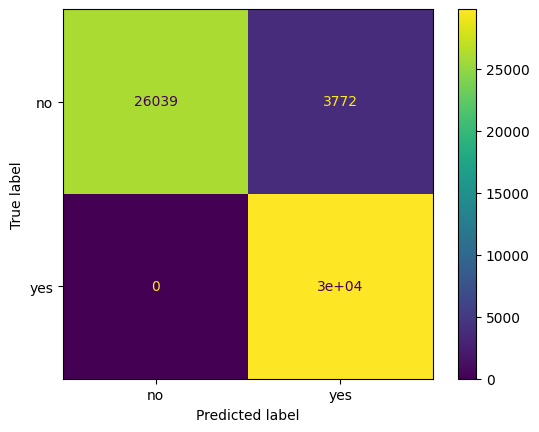

In [16]:
cm_train_oversampled_knn5 = confusion_matrix(y_train_over, y_train_pred_knn5_over)

disp_train_over_knn5 = ConfusionMatrixDisplay(cm_train_oversampled_knn5, display_labels=top_model_knn5_over.classes_)
disp_train_over_knn5.plot()
plt.savefig('../Slides/conf_matrix_train_oversampled_knn5.png', dpi=300, transparent=True)
plt.show()

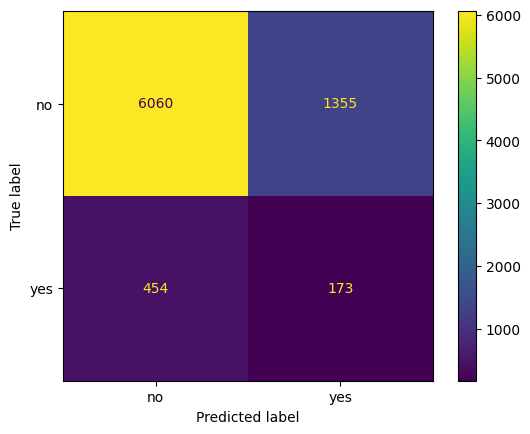

In [17]:
cm_test_oversampled_knn = confusion_matrix(y_test, y_test_pred_knn5_over)

disp_test_over_knn = ConfusionMatrixDisplay(cm_test_oversampled_knn, display_labels=top_model_knn5_over.classes_)
disp_test_over_knn.plot()
plt.savefig('../Slides/conf_matrix_test_oversampled_knn5.png', dpi=300, transparent=True)
plt.show()

In [18]:
print("The accuracy in the TRAIN set is: {:.3f}".format(accuracy_score(y_train_over, y_train_pred_knn5_over)))
print("The accuracy in the TEST  set is: {:.3f}".format(accuracy_score(y_test, y_test_pred_knn5_over)))
print(classification_report(y_test, y_test_pred_knn5_over, target_names=['No','Yes']))
print(cohen_kappa_score(y_train_over, y_train_pred_knn5_over))

The accuracy in the TRAIN set is: 0.937
The accuracy in the TEST  set is: 0.775
              precision    recall  f1-score   support

          No       0.93      0.82      0.87      7415
         Yes       0.11      0.28      0.16       627

    accuracy                           0.78      8042
   macro avg       0.52      0.55      0.52      8042
weighted avg       0.87      0.78      0.81      8042

0.8734695246721009


# Model 2: Oversampled and KNN 3

In [19]:
top_model_knn3_over = KNeighborsClassifier(n_neighbors=3, weights = "uniform", p=1).fit(X_train_over, y_train_over)
topscore3_over = top_model_knn3_over.score(X_test_transformed, y_test)

print("The score for the K-NN model with 5 neighbours, weighted by uniform is {:.3f}".format(topscore3_over))

The score for the K-NN model with 5 neighbours, weighted by uniform is 0.819


In [20]:
y_train_pred_knn3_over = top_model_knn3_over.predict(X_train_over)
y_test_pred_knn3_over  = top_model_knn3_over.predict(X_test_transformed)

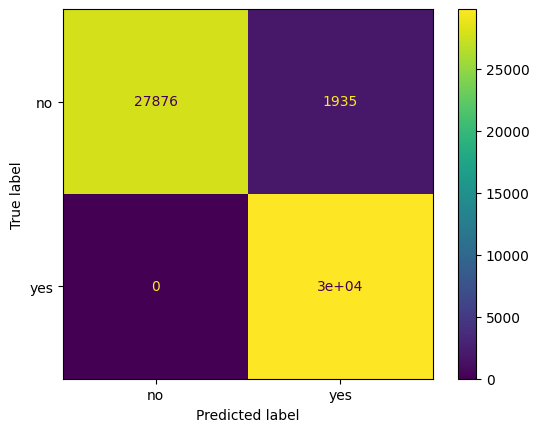

In [21]:
cm_train_oversampled_knn3 = confusion_matrix(y_train_over, y_train_pred_knn3_over)

disp_train_over_knn3 = ConfusionMatrixDisplay(cm_train_oversampled_knn3, display_labels=top_model_knn3_over.classes_)
disp_train_over_knn3.plot()
plt.savefig('../Slides/conf_matrix_train_oversampled_knn3.png', dpi=300, transparent=True)
plt.show()

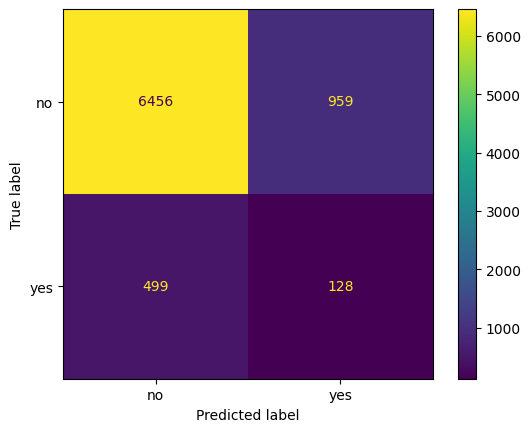

In [22]:
cm_test_oversampled_knn3 = confusion_matrix(y_test, y_test_pred_knn3_over)

disp_test_over_knn3 = ConfusionMatrixDisplay(cm_test_oversampled_knn3, display_labels=top_model_knn3_over.classes_)
disp_test_over_knn3.plot()
plt.savefig('../Slides/conf_matrix_test_oversampled_knn3.png', dpi=300, transparent=True)
plt.show()

In [23]:
print("The accuracy in the TRAIN set is: {:.3f}".format(accuracy_score(y_train_over, y_train_pred_knn3_over)))
print("The accuracy in the TEST  set is: {:.3f}".format(accuracy_score(y_test, y_test_pred_knn3_over)))
print(classification_report(y_test, y_test_pred_knn3_over, target_names=['No','Yes']))
print(cohen_kappa_score(y_train_over, y_train_pred_knn3_over))

The accuracy in the TRAIN set is: 0.968
The accuracy in the TEST  set is: 0.819
              precision    recall  f1-score   support

          No       0.93      0.87      0.90      7415
         Yes       0.12      0.20      0.15       627

    accuracy                           0.82      8042
   macro avg       0.52      0.54      0.52      8042
weighted avg       0.87      0.82      0.84      8042

0.9350910737647178


# Model 3: SMOTE and KNN 5

In [24]:
sm = SMOTE(random_state=23)
X_train_SMOTE,y_train_SMOTE = sm.fit_resample(X_train_transformed,y_train)

In [25]:
topmodel_knn5_smote = KNeighborsClassifier(n_neighbors=5, weights = "uniform", p=3).fit(X_train_SMOTE, y_train_SMOTE)
topscore5_smote = topmodel_knn5_smote.score(X_test_transformed, y_test)

print("The score for the K-NN model with 5 neighbours, weighted by uniform is {:.3f}".format(topscore5_smote))

The score for the K-NN model with 5 neighbours, weighted by uniform is 0.630


In [26]:
y_train_pred_knn5_smote = topmodel_knn5_smote.predict(X_train_SMOTE)
y_test_pred_knn5_smote  = topmodel_knn5_smote.predict(X_test_transformed)

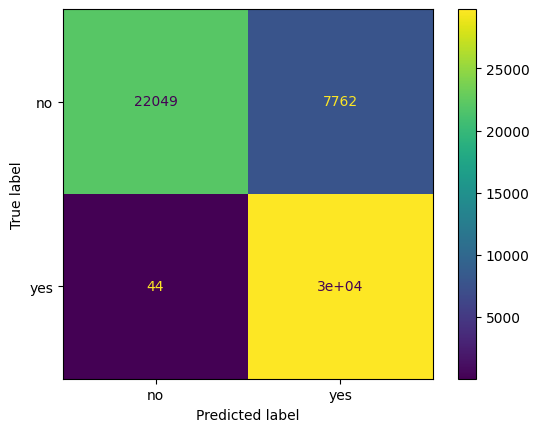

In [28]:
cm_train_smote_knn5 = confusion_matrix(y_train_over, y_train_pred_knn5_smote)

disp_train_smote_knn5 = ConfusionMatrixDisplay(cm_train_smote_knn5, display_labels=topmodel_knn5_smote.classes_)
disp_train_smote_knn5.plot()
plt.savefig('../Slides/conf_matrix_train_smoted_knn5.png', dpi=300, transparent=True)
plt.show()

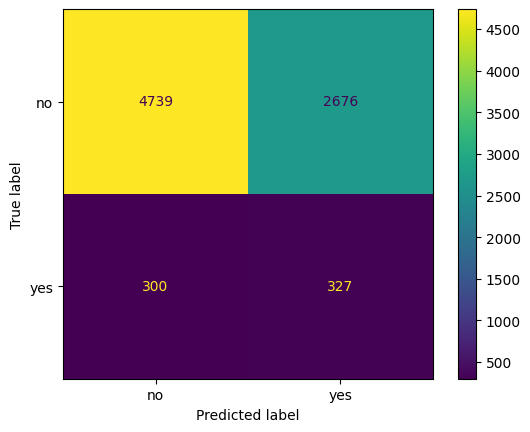

In [30]:
cm_test_smote_knn5 = confusion_matrix(y_test, y_test_pred_knn5_smote)

disp_test_smote_knn5 = ConfusionMatrixDisplay(cm_test_smote_knn5, display_labels=topmodel_knn5_smote.classes_)
disp_test_smote_knn5.plot()
plt.savefig('../Slides/conf_matrix_test_smoted_knn5.png', dpi=300, transparent=True)
plt.show()

In [32]:
#print("The accuracy in the TRAIN set is: {:.3f}".format(accuracy_score(X_train_SMOTE, y_train_pred_knn5_smote)))
print("The accuracy in the TEST  set is: {:.3f}".format(accuracy_score(y_test, y_test_pred_knn5_smote)))
print(classification_report(y_test, y_test_pred_knn5_over, target_names=['No','Yes']))
print(cohen_kappa_score(y_train_SMOTE, y_train_pred_knn5_smote))

The accuracy in the TEST  set is: 0.630
              precision    recall  f1-score   support

          No       0.93      0.82      0.87      7415
         Yes       0.11      0.28      0.16       627

    accuracy                           0.78      8042
   macro avg       0.52      0.55      0.52      8042
weighted avg       0.87      0.78      0.81      8042

0.7381503471872799


# Model 4: SMOTE and KNN 3

In [33]:
topmodel_knn3_smote = KNeighborsClassifier(n_neighbors=3, weights = "uniform", p=3).fit(X_train_SMOTE, y_train_SMOTE)
topscore3_smote = topmodel_knn3_smote.score(X_test_transformed, y_test)

print("The score for the K-NN model with 5 neighbours, weighted by uniform is {:.3f}".format(topscore3_smote))

The score for the K-NN model with 5 neighbours, weighted by uniform is 0.673


In [34]:
y_train_pred_knn3_smote = topmodel_knn3_smote.predict(X_train_SMOTE)
y_test_pred_knn3_smote  = topmodel_knn3_smote.predict(X_test_transformed)

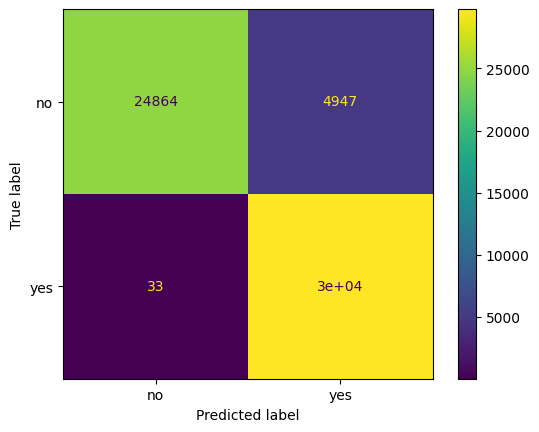

In [35]:
cm_train_smote_knn3 = confusion_matrix(y_train_over, y_train_pred_knn3_smote)

disp_train_smote_knn3 = ConfusionMatrixDisplay(cm_train_smote_knn3, display_labels=topmodel_knn3_smote.classes_)
disp_train_smote_knn3.plot()
plt.savefig('../Slides/conf_matrix_train_smoted_knn3.png', dpi=300, transparent=True)
plt.show()

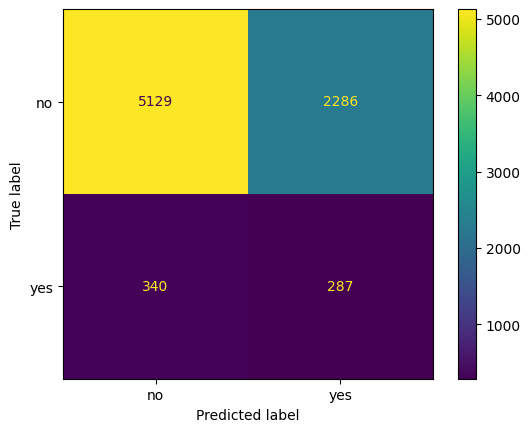

In [36]:
cm_test_smote_knn3 = confusion_matrix(y_test, y_test_pred_knn3_smote)

disp_test_smote_knn3 = ConfusionMatrixDisplay(cm_test_smote_knn3, display_labels=topmodel_knn3_smote.classes_)
disp_test_smote_knn3.plot()
plt.savefig('../Slides/conf_matrix_test_smoted_knn5.png', dpi=300, transparent=True)
plt.show()

In [38]:
#print("The accuracy in the TRAIN set is: {:.3f}".format(accuracy_score(X_train_SMOTE, y_train_pred_knn3_smote)))
print("The accuracy in the TEST  set is: {:.3f}".format(accuracy_score(y_test, y_test_pred_knn3_smote)))
print(classification_report(y_test, y_test_pred_knn3_over, target_names=['No','Yes']))
print(cohen_kappa_score(y_train_SMOTE, y_train_pred_knn3_smote))

The accuracy in the TEST  set is: 0.673
              precision    recall  f1-score   support

          No       0.93      0.87      0.90      7415
         Yes       0.12      0.20      0.15       627

    accuracy                           0.82      8042
   macro avg       0.52      0.54      0.52      8042
weighted avg       0.87      0.82      0.84      8042

0.8329475696890409


# Model selected: 2

In [39]:
with open('../Models/knn3_oversampled.pkl', 'wb') as file:
    pickle.dump(top_model_knn3_over, file)